In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from utils import *

path = "/Users/peter/Work/radiography/data/"
path_sim = "/Users/peter/Work/semiempirical_transparency/out/"
outfile = "/Users/peter/Work/semiempirical_transparency/paper/figs/"

H = "9.7"
L = "6"
H_twiddle = "10"
L_twiddle = "5.7"
thetaMax = np.arcsin(400 / 700)

### Loading simulated parameters

In [2]:
b_10 = np.load(path + "b10MeV_10.npy")
b_97 = np.load(path + "b9.7MeV_10.npy")
b_6 = np.load(path + "b6MeV_10.npy")
b_4 = np.load(path + "b4MeV_10.npy")
 
R = np.load(path + "R_10.npy")
E_g = np.load(path + "E_g_10.npy")
E_dep = np.load(path + "E_dep_10.npy")

lmbdaRange = np.linspace(0, 500, 101)
zRange = np.arange(1, 101)
attenMat = calcAttenMat_tot(E_g, zRange)
attenMat_PE = calcAttenMat_PE(E_g, zRange)
attenMat_CS = calcAttenMat_CS(E_g, zRange)
attenMat_PP = calcAttenMat_PP(E_g, zRange)
  
if (H, L) == ("6", "4"):
    b_H = b_6
    b_L = b_4
    yrange = [-2, 0]
elif (H, L) == ("10", "6"):
    b_H = b_10
    b_L = b_6
    yrange = [-2, 0]
elif (H, L) == ("9.7", "6"):
    b_H = b_97
    b_L = b_6
    yrange = [-2, 0]
elif (H, L) == ("10", "4"):
    b_H = b_10
    b_L = b_4
    yrange = [-4, 0]
else:
    raise ValueError("'H' or 'L' not understood, must be '10', '6', or '4'")
    
norm = mpl.colors.Normalize(vmin=zRange[0], vmax=zRange[-1])
colormap = mpl.colormaps["viridis"]
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
color = lambda Z: cmap.to_rgba(Z)
n = len(lmbdaRange)
xrange = [0, 10]
xticks = np.arange(11)
yticks = np.linspace(np.ceil(2*yrange[0])/2, np.floor(2*yrange[1])/2, int(2*(yrange[1] - yrange[0]) + 1))

### Adding Compound Materials

In [3]:
compound_material = {}
compound_Z = {}
compound_f = {}
compound_c = {}

compound_material[101] = "Polyethylene (CH2)"
compound_Z[101] = np.array([1, 6])
compound_f[101] = np.array([0.143711, 0.856289])
compound_c[101] = color(6)

compound_material[102] = "Silver Chloride (AgCl)"
compound_Z[102] = np.array([17, 47])
compound_f[102] = np.array([0.247368, 0.752632])
compound_c[102] = color(47)

compound_material[103] = "Uranium Oxide (UO2)"
compound_Z[103] = np.array([8, 92])
compound_f[103] = np.array([0.118502, 0.881498])
compound_c[103] = color(92)

### Loading simulated data

In [4]:
energies = np.array(["10", "6", "4", "9.7", "6.3", "5.7"])

### Calibration data
# lookup_alpha_calib = calcLookupTables("lookup_alpha_calib.npy", path_sim + "calib/", energies, thetaMax, R, E_dep, attenMat, zRange)
lookup_alpha_calib = calcLookupTables("lookup_alpha_calib.npy")
Z_arr_calib, Z_vals_calib, Z_compound_calib, alpha_H_calib, alpha_L_calib, sigma_H_calib, sigma_L_calib, lmbda_H_calib, lmbda_L_calib = extractFromTables(lookup_alpha_calib, H, L)
Z_arr_calib_twiddle, Z_vals_calib_twiddle, Z_compound_calib_twiddle, alpha_H_calib_twiddle, alpha_L_calib_twiddle, sigma_H_calib_twiddle, sigma_L_calib_twiddle, lmbda_H_calib_twiddle, lmbda_L_calib_twiddle = extractFromTables(lookup_alpha_calib, H_twiddle, L_twiddle)

### Test data
# lookup_alpha = calcLookupTables("lookup_alpha.npy", path_sim, energies, thetaMax, R, E_dep, attenMat, zRange, compound_Z, compound_f)
lookup_alpha = calcLookupTables("lookup_alpha.npy")
Z_arr, Z_vals, Z_compound, alpha_H_arr, alpha_L_arr, sigma_H_arr, sigma_L_arr, lmbda_H_arr, lmbda_L_arr = extractFromTables(lookup_alpha, H, L)
Z_arr_twiddle, Z_vals_twiddle, Z_compound_twiddle, alpha_H_arr_twiddle, alpha_L_arr_twiddle, sigma_H_arr_twiddle, sigma_L_arr_twiddle, lmbda_H_arr_twiddle, lmbda_L_arr_twiddle = extractFromTables(lookup_alpha, H_twiddle, L_twiddle)

### Plotting simulated data against the free streaming model

Bias_H = 0.048
Bias_L = 0.0269


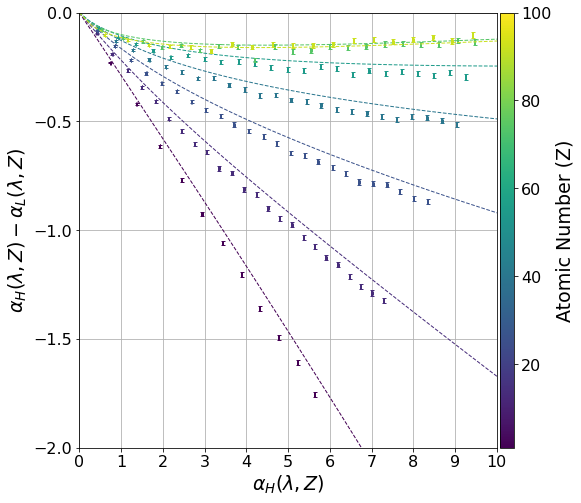

In [5]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, b_H, R, E_dep, attenMat, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, b_L, R, E_dep, attenMat, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_freestreaming.png", bbox_inches = "tight")

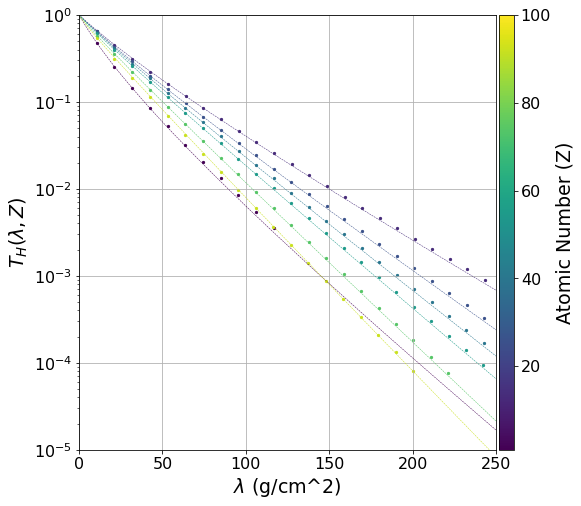

In [6]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    #ax.errorbar(lmbda_H, alpha_H, yerr = sigma_H, 
    #             elinewidth=2, capsize=1, ecolor = color(Z), ls='none')
    ax.scatter(lmbda_H, np.exp(-alpha_H), s=5, color = color(Z))
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat, zRange)
    ax.plot(lmbdaRange, np.exp(-alpha_H0), linewidth = 0.5, linestyle = 'dashed', c=color(Z))

ax.set_xlim([0, 250])
ax.set_ylim([1e-5, 1])
ax.semilogy()
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\lambda$ (g/cm^2)", fontsize=19)
ax.set_ylabel(r"$T_H(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "T_H_lambda.png", bbox_inches = "tight")

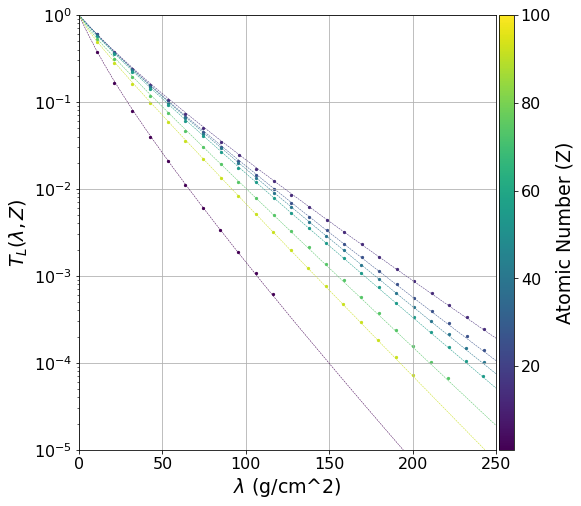

In [7]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    #ax.errorbar(lmbda_L, alpha_L, yerr = sigma_L, 
    #             elinewidth=2, capsize=1, ecolor = color(Z), ls='none')
    ax.scatter(lmbda_L, np.exp(-alpha_L), s=5, color = color(Z))
        
    ### plot against theory
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat, zRange)
    ax.plot(lmbdaRange, np.exp(-alpha_L0), linewidth = 0.5, linestyle = 'dashed', c=color(Z))

ax.set_xlim([0, 250])
ax.set_ylim([1e-5, 1])
ax.semilogy()
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\lambda$ (g/cm^2)", fontsize=19)
ax.set_ylabel(r"$T_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "T_L_lambda.png", bbox_inches = "tight")

### Z of best fit

True Z: 1; Fit Z: [1]; Loss: [0.00187487]
True Z: 6; Fit Z: [5]; Loss: [0.00013884]
True Z: 13; Fit Z: [12]; Loss: [0.00022987]
True Z: 20; Fit Z: [18]; Loss: [9.93471671e-05]
True Z: 26; Fit Z: [24]; Loss: [9.76089655e-05]
True Z: 32; Fit Z: [29]; Loss: [8.76051312e-05]
True Z: 40; Fit Z: [37]; Loss: [9.22838899e-05]
True Z: 47; Fit Z: [43]; Loss: [8.22021623e-05]
True Z: 55; Fit Z: [51]; Loss: [6.4800084e-05]
True Z: 64; Fit Z: [ 59 100]; Loss: [0.00011248 0.00013821]
True Z: 74; Fit Z: [68 93]; Loss: [0.00015232 0.00010342]
True Z: 82; Fit Z: [88]; Loss: [0.00012957]
True Z: 92; Fit Z: [87]; Loss: [7.73600047e-05]


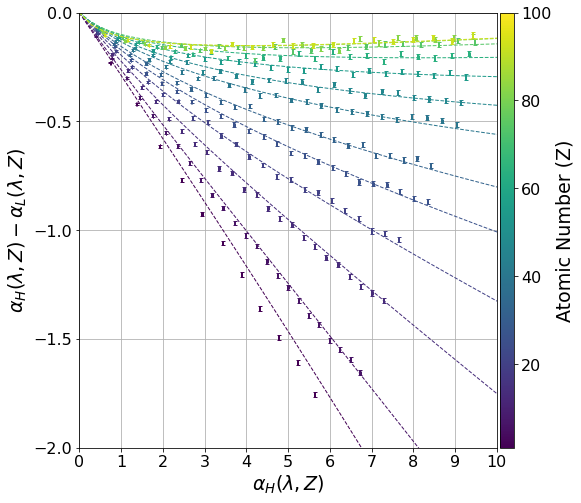

In [8]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, b_H, b_L, R, E_dep, attenMat, attenMat, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_H, R, E_dep, attenMat, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_L, R, E_dep, attenMat, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Semiempirical mass attenuation coefficient

Minimum found at a = 1.1536, b=0.9869, c=0.9914 with a loss of 2.402e-04
Minimum found at a = 1.1045, b=1.0054, c=0.9612 with a loss of 4.931e-04
Bias_H = 0.0141483
Bias_L = 0.0211615


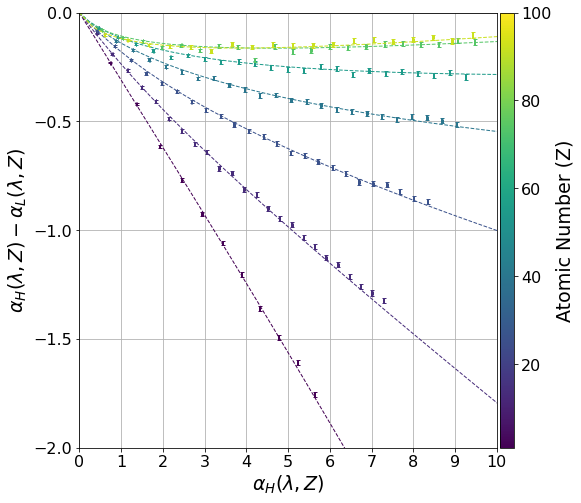

In [9]:
a0_H, b0_H, c0_H = fitSemiempirical(alpha_H_arr, lmbda_H_arr, Z_arr, b_H, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
a0_L, b0_L, c0_L = fitSemiempirical(alpha_L_arr, lmbda_L_arr, Z_arr, b_L, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
attenMat_H = attenMat + (a0_H-1)*attenMat_PE + (b0_H-1)*attenMat_CS + (c0_H-1)*attenMat_PP
attenMat_L = attenMat + (a0_L-1)*attenMat_PE + (b0_L-1)*attenMat_CS + (c0_L-1)*attenMat_PP

fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, b_H, R, E_dep, attenMat_H, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, b_L, R, E_dep, attenMat_L, zRange)
print("Bias_H = %.6g" % bias_H)
print("Bias_L = %.6g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_semiempirical.png", bbox_inches = "tight")

### Z of best fit using semiempirical parameters

True Z: 1; Fit Z: [1]; Loss: [5.62209672e-05]
True Z: 6; Fit Z: [6]; Loss: [0.00014883]
True Z: 13; Fit Z: [13]; Loss: [0.00011835]
True Z: 20; Fit Z: [20]; Loss: [8.24479707e-05]
True Z: 26; Fit Z: [26]; Loss: [4.55624579e-05]
True Z: 32; Fit Z: [32]; Loss: [5.93181729e-05]
True Z: 40; Fit Z: [40]; Loss: [4.66438379e-05]
True Z: 47; Fit Z: [46]; Loss: [6.33318631e-05]
True Z: 55; Fit Z: [55]; Loss: [4.87667555e-05]
True Z: 64; Fit Z: [63]; Loss: [8.09911717e-05]
True Z: 74; Fit Z: [74 96]; Loss: [1.07659720e-04 9.31117711e-05]
True Z: 82; Fit Z: [89]; Loss: [9.00025643e-05]
True Z: 92; Fit Z: [88]; Loss: [4.54313733e-05]


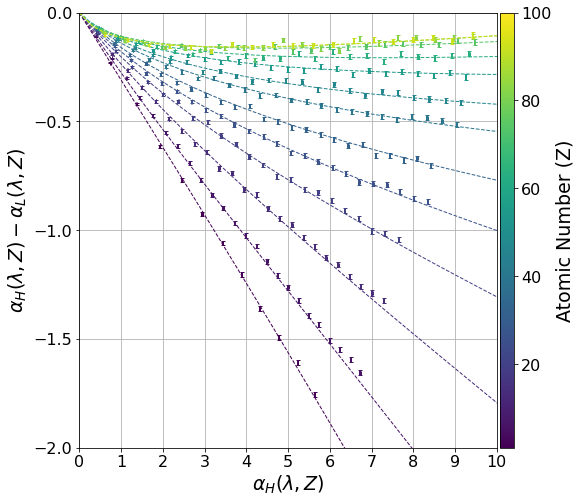

In [10]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, b_H, b_L, R, E_dep, attenMat_H, attenMat_L, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_L, R, E_dep, attenMat_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

    ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Calibrate using Z=6, Z=26, and Z=82

Minimum found at a = 1.0992, b=0.9868, c=0.9934 with a loss of 7.373e-13
Minimum found at a = 0.9803, b=1.0025, c=0.9842 with a loss of 4.618e-12
Bias_H = 0.0151
Bias_L = 0.0239


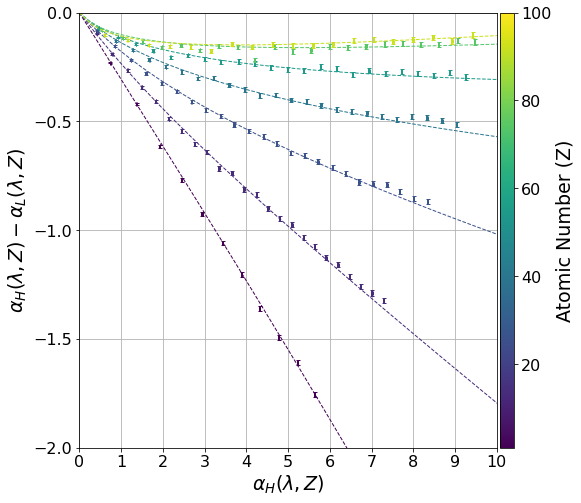

In [11]:
fig, ax = plt.subplots(1, figsize = [8, 8])

lmbda_calib = 150
cut = np.abs(lmbda_H_calib - 1.068*lmbda_calib) < 10
a0_H, b0_H, c0_H = fitSemiempirical(alpha_H_calib[cut], lmbda_H_calib[cut], Z_arr_calib[cut], b_H, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
a0_L, b0_L, c0_L = fitSemiempirical(alpha_L_calib[cut], lmbda_L_calib[cut], Z_arr_calib[cut], b_L, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)

attenMat_H = attenMat + (a0_H-1)*attenMat_PE + (b0_H-1)*attenMat_CS + (c0_H-1)*attenMat_PP
attenMat_L = attenMat + (a0_L-1)*attenMat_PE + (b0_L-1)*attenMat_CS + (c0_L-1)*attenMat_PP

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr, sigma_H_arr, lmbda_H_arr, Z_arr, b_H, R, E_dep, attenMat_H, zRange)
bias_L = calcBias(alpha_L_arr, sigma_L_arr, lmbda_L_arr, Z_arr, b_L, R, E_dep, attenMat_L, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

True Z: 1; Fit Z: [1]; Loss: [7.75489987e-05]
True Z: 6; Fit Z: [6]; Loss: [7.93049639e-05]
True Z: 13; Fit Z: [13]; Loss: [0.00010788]
True Z: 20; Fit Z: [20]; Loss: [9.98726249e-05]
True Z: 26; Fit Z: [26]; Loss: [8.66743783e-05]
True Z: 32; Fit Z: [32]; Loss: [6.25927046e-05]
True Z: 40; Fit Z: [41]; Loss: [7.32679699e-05]
True Z: 47; Fit Z: [47]; Loss: [7.71257732e-05]
True Z: 55; Fit Z: [56]; Loss: [6.68762233e-05]
True Z: 64; Fit Z: [65]; Loss: [0.00011919]
True Z: 74; Fit Z: [ 74 100]; Loss: [1.55597252e-04 9.50915588e-05]
True Z: 82; Fit Z: [83 95]; Loss: [0.00016579 0.00011066]
True Z: 92; Fit Z: [95]; Loss: [5.92584893e-05]


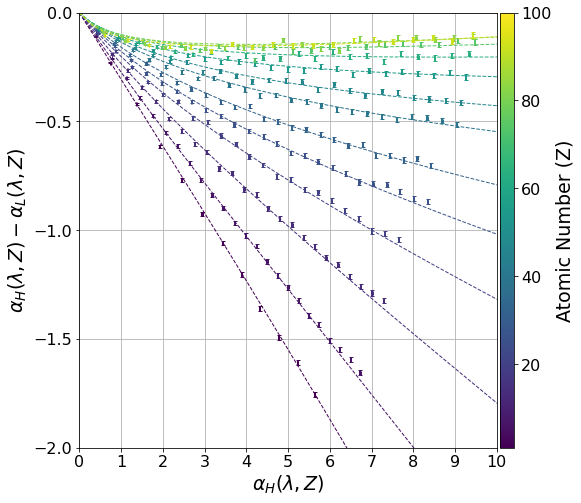

In [12]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, b_H, b_L, R, E_dep, attenMat_H, attenMat_L, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_L, R, E_dep, attenMat_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Source Energy Fluctuations, free streaming

Bias_H = 0.0704
Bias_L = 0.0787


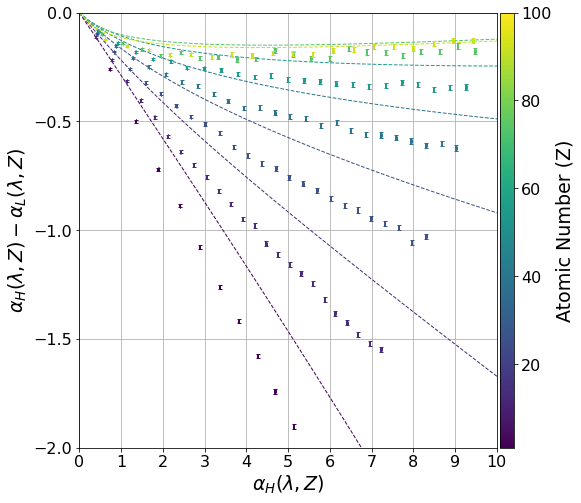

In [13]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H_twiddle][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L_twiddle][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr_twiddle, sigma_H_arr_twiddle, lmbda_H_arr_twiddle, Z_arr_twiddle, b_H, R, E_dep, attenMat, zRange)
bias_L = calcBias(alpha_L_arr_twiddle, sigma_L_arr_twiddle, lmbda_L_arr_twiddle, Z_arr_twiddle, b_L, R, E_dep, attenMat, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_freestreaming_mismatched.png", bbox_inches = "tight")

True Z: 1; Fit Z: [1]; Loss: [0.02990176]
True Z: 6; Fit Z: [1]; Loss: [0.00075829]
True Z: 13; Fit Z: [7]; Loss: [0.00051956]
True Z: 20; Fit Z: [14]; Loss: [0.0003697]
True Z: 26; Fit Z: [19]; Loss: [0.00031698]
True Z: 32; Fit Z: [25]; Loss: [0.00028288]
True Z: 40; Fit Z: [32]; Loss: [0.00025628]
True Z: 47; Fit Z: [39]; Loss: [0.00023052]
True Z: 55; Fit Z: [46]; Loss: [0.00023979]
True Z: 64; Fit Z: [53]; Loss: [0.00030892]
True Z: 74; Fit Z: [ 61 100]; Loss: [0.00039699 0.00017985]
True Z: 82; Fit Z: [63 99]; Loss: [0.00040962 0.00018754]
True Z: 92; Fit Z: [65 97]; Loss: [0.00048408 0.00024002]


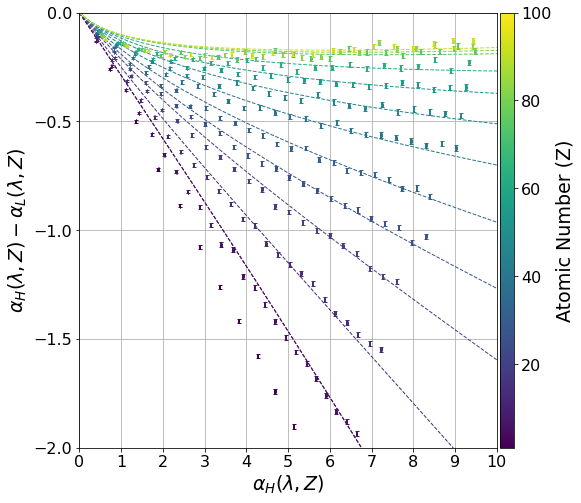

In [14]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H_twiddle][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L_twiddle][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, b_H, b_L, R, E_dep, attenMat, attenMat, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_H, R, E_dep, attenMat, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_L, R, E_dep, attenMat, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Source Energy Fluctuations, semiempirical

Minimum found at a = 1.0496, b=0.9654, c=1.0287 with a loss of 5.943e-12
Minimum found at a = 1.1173, b=1.0375, c=0.9115 with a loss of 1.449e-11
Bias_H = 0.0167
Bias_L = 0.0212


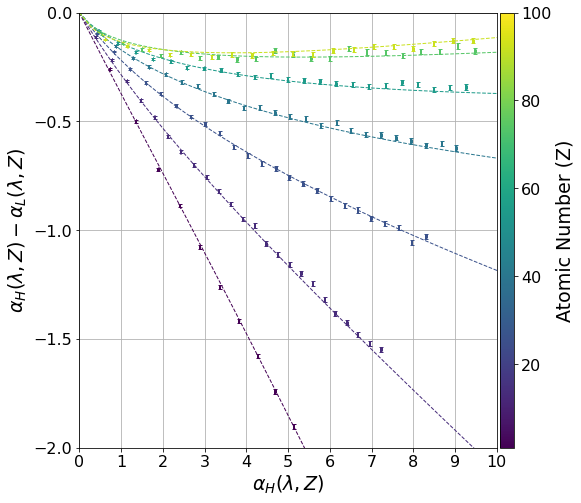

In [15]:
fig, ax = plt.subplots(1, figsize = [8, 8])

lmbda_calib = 150
cut = np.abs(lmbda_H_calib_twiddle - 1.068*lmbda_calib) < 10
a0_H, b0_H, c0_H = fitSemiempirical(alpha_H_calib_twiddle[cut], lmbda_H_calib_twiddle[cut], Z_arr_calib_twiddle[cut], b_H, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
a0_L, b0_L, c0_L = fitSemiempirical(alpha_L_calib_twiddle[cut], lmbda_L_calib_twiddle[cut], Z_arr_calib_twiddle[cut], b_L, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)

attenMat_H = attenMat + (a0_H-1)*attenMat_PE + (b0_H-1)*attenMat_CS + (c0_H-1)*attenMat_PP
attenMat_L = attenMat + (a0_L-1)*attenMat_PE + (b0_L-1)*attenMat_CS + (c0_L-1)*attenMat_PP

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H_twiddle][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L_twiddle][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

bias_H = calcBias(alpha_H_arr_twiddle, sigma_H_arr_twiddle, lmbda_H_arr_twiddle, Z_arr_twiddle, b_H, R, E_dep, attenMat_H, zRange)
bias_L = calcBias(alpha_L_arr_twiddle, sigma_L_arr_twiddle, lmbda_L_arr_twiddle, Z_arr_twiddle, b_L, R, E_dep, attenMat_L, zRange)
print("Bias_H = %.3g" % bias_H)
print("Bias_L = %.3g" % bias_L)

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_semiempirical_mismatched.png", bbox_inches = "tight")

True Z: 1; Fit Z: [1]; Loss: [5.57067201e-05]
True Z: 6; Fit Z: [6]; Loss: [0.00012205]
True Z: 13; Fit Z: [13]; Loss: [0.0001074]
True Z: 20; Fit Z: [20]; Loss: [5.55890942e-05]
True Z: 26; Fit Z: [26]; Loss: [5.74876845e-05]
True Z: 32; Fit Z: [32]; Loss: [4.95866727e-05]
True Z: 40; Fit Z: [41]; Loss: [4.24208593e-05]
True Z: 47; Fit Z: [48]; Loss: [5.57927756e-05]
True Z: 55; Fit Z: [56]; Loss: [4.53614651e-05]
True Z: 64; Fit Z: [66]; Loss: [0.00010878]
True Z: 74; Fit Z: [ 77 100]; Loss: [0.00013373 0.00018753]
True Z: 82; Fit Z: [ 80 100]; Loss: [1.13833485e-04 7.94009196e-05]
True Z: 92; Fit Z: [98]; Loss: [2.43804289e-05]


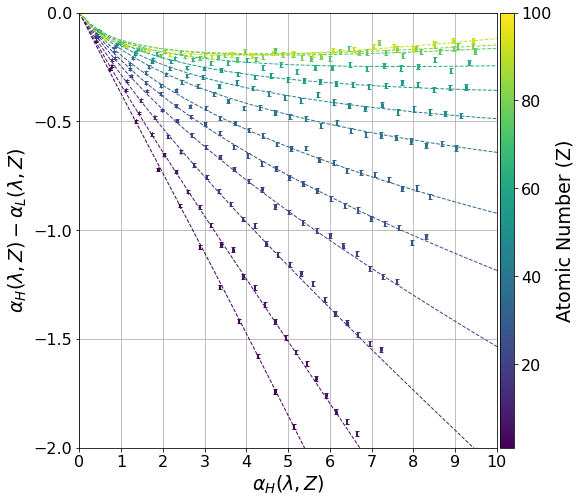

In [16]:
fig, ax = plt.subplots(1, figsize = [8, 8])

for Z in Z_vals:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H_twiddle][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L_twiddle][Z]
    ax.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
        
    Z_fit, loss_fit = fitToTheory(alpha_H, alpha_L, b_H, b_L, R, E_dep, attenMat_H, attenMat_L, zRange)
    print("True Z: %d; Fit Z: %s; Loss: %s" % (Z, Z_fit, loss_fit))
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z_fit[0]], b_L, R, E_dep, attenMat_L, zRange)        
    ax.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax.set_xlim(xrange)
ax.set_ylim(yrange)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.025, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

### Compound Materials

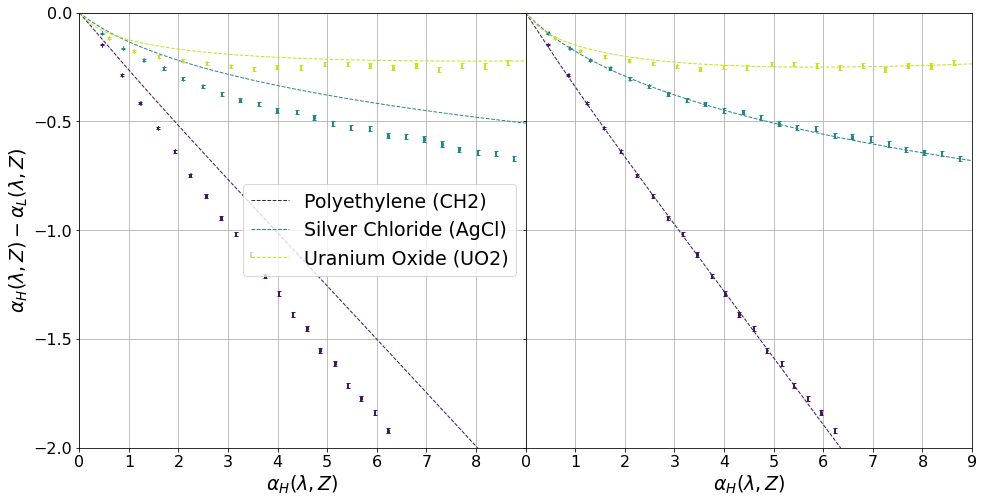

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [16, 8], sharey = True)
fig.subplots_adjust(wspace=0)

for Z in Z_compound:        
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H_twiddle][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L_twiddle][Z]
    ax1.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = compound_c[Z], ls='none')
    ax2.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = compound_c[Z], ls='none') 
        
    ### plot against theory
    alpha_H0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], b_H, R, E_dep, attenMat, zRange) for lmbda in lmbdaRange])
    alpha_L0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], b_L, R, E_dep, attenMat, zRange) for lmbda in lmbdaRange])
    ax1.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', color = compound_c[Z], label = compound_material[Z])
    
    alpha_H0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], b_H, R, E_dep, attenMat_H, zRange) for lmbda in lmbdaRange])
    alpha_L0 = np.array([calcCompoundAlpha(lmbda*compound_f[Z], compound_Z[Z], b_L, R, E_dep, attenMat_L, zRange) for lmbda in lmbdaRange])
    ax2.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', color = compound_c[Z], label = compound_material[Z])

ax1.set_xlim([0,9])
ax2.set_xlim([0,9])
ax1.set_ylim(yrange)
ax1.set_xticks(np.arange(9))
ax2.set_xticks(np.arange(10))
ax1.set_yticks(yticks)
ax1.tick_params(labelsize=16)
ax2.tick_params(labelsize=16)
ax1.grid()
ax2.grid()
ax1.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax2.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax1.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
ax1.legend(fontsize=19)

plt.savefig(outfile + "alpha_curve_compound.png", bbox_inches = "tight")

### Results summary

Minimum found at a = 1.1536, b=0.9869, c=0.9914 with a loss of 2.402e-04
Minimum found at a = 1.1045, b=1.0054, c=0.9612 with a loss of 4.931e-04
Minimum found at a = 1.0496, b=0.9654, c=1.0287 with a loss of 5.943e-12
Minimum found at a = 1.1173, b=1.0375, c=0.9115 with a loss of 1.449e-11


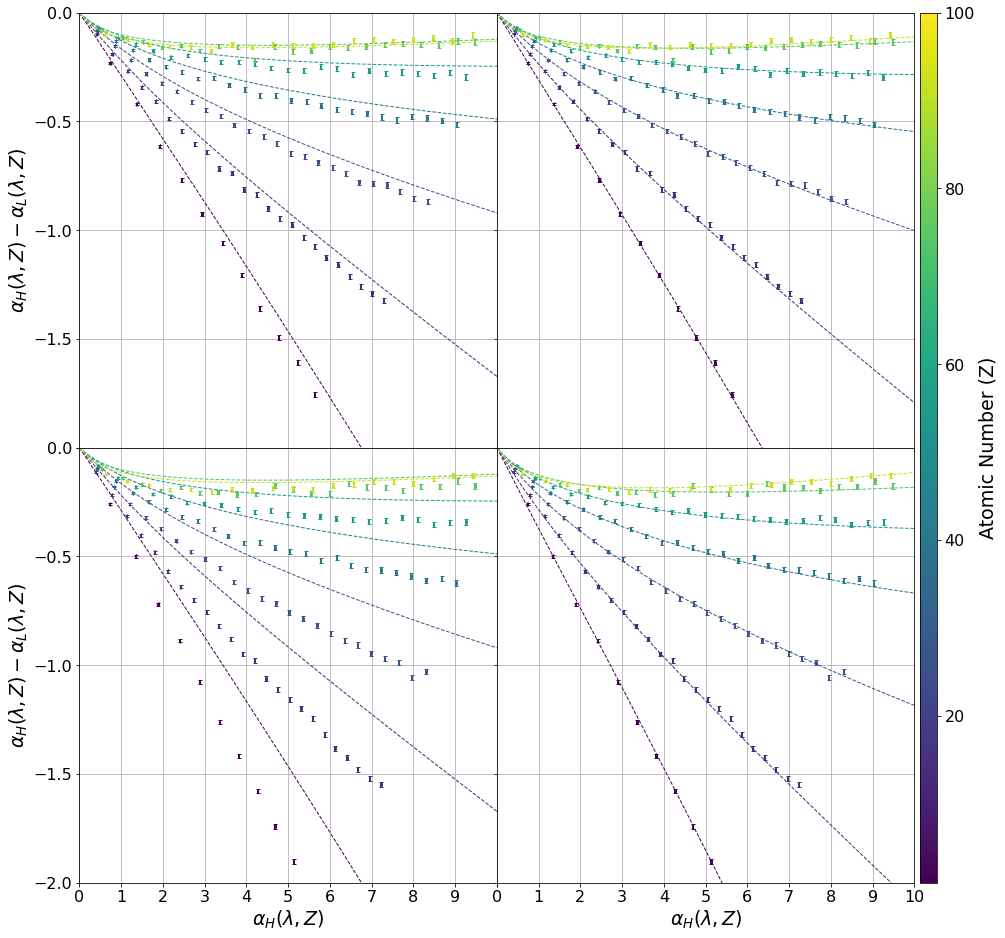

In [18]:
a0_H, b0_H, c0_H = fitSemiempirical(alpha_H_arr, lmbda_H_arr, Z_arr, b_H, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
a0_L, b0_L, c0_L = fitSemiempirical(alpha_L_arr, lmbda_L_arr, Z_arr, b_L, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
attenMat_H = attenMat + (a0_H-1)*attenMat_PE + (b0_H-1)*attenMat_CS + (c0_H-1)*attenMat_PP
attenMat_L = attenMat + (a0_L-1)*attenMat_PE + (b0_L-1)*attenMat_CS + (c0_L-1)*attenMat_PP

lmbda_calib = 150
cut = np.abs(lmbda_H_calib_twiddle - 1.068*lmbda_calib) < 10
a0_H, b0_H, c0_H = fitSemiempirical(alpha_H_calib_twiddle[cut], lmbda_H_calib_twiddle[cut], Z_arr_calib_twiddle[cut], b_H, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
a0_L, b0_L, c0_L = fitSemiempirical(alpha_L_calib_twiddle[cut], lmbda_L_calib_twiddle[cut], Z_arr_calib_twiddle[cut], b_L, R, E_dep, attenMat, attenMat_PE, attenMat_CS, attenMat_PP, zRange)
attenMat_H_twiddle = attenMat + (a0_H-1)*attenMat_PE + (b0_H-1)*attenMat_CS + (c0_H-1)*attenMat_PP
attenMat_L_twiddle = attenMat + (a0_L-1)*attenMat_PE + (b0_L-1)*attenMat_CS + (c0_L-1)*attenMat_PP

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize = [16, 16], sharex = True, sharey = True)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

for Z in Z_vals[::2]:
    ### lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L][Z]
    ax11.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                  yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                  elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
    ax12.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                  yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                  elinewidth=2, capsize=2, ecolor = color(Z), ls='none') 
    
    ### plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat, zRange)        
    ax11.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))
    
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat_H, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat_L, zRange)        
    ax12.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))
    
    
    ### TWIDDLE: lookup simulated values
    lmbda_H, alpha_H, sigma_H = lookup_alpha[H_twiddle][Z]
    lmbda_L, alpha_L, sigma_L = lookup_alpha[L_twiddle][Z]
    ax21.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none')
    ax22.errorbar(alpha_H, alpha_H - alpha_L, xerr = sigma_H, 
                 yerr = np.sqrt(sigma_H**2 + sigma_L**2), 
                 elinewidth=2, capsize=2, ecolor = color(Z), ls='none') 
    
    ### TWIDDLE: plot against theory
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat, zRange)        
    ax21.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))
    
    alpha_H0 = calcAlpha(lmbdaRange, [Z], b_H, R, E_dep, attenMat_H_twiddle, zRange)
    alpha_L0 = calcAlpha(lmbdaRange, [Z], b_L, R, E_dep, attenMat_L_twiddle, zRange)        
    ax22.plot(alpha_H0, alpha_H0 - alpha_L0, linewidth = 1, linestyle = 'dashed', c=color(Z))

ax11.set_xlim(xrange)
ax11.set_ylim(yrange)
ax11.set_xticks(xticks)
ax11.set_yticks(yticks)

plt.setp(ax11.get_yticklabels()[0], visible=False)
plt.setp(ax21.get_xticklabels()[-1], visible=False)

ax11.tick_params(labelsize=16)
ax12.tick_params(labelsize=16)
ax21.tick_params(labelsize=16)
ax22.tick_params(labelsize=16)
ax11.grid()
ax12.grid()
ax21.grid()
ax22.grid()
ax21.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax22.set_xlabel(r"$\alpha_H(\lambda, Z)$", fontsize=19)
ax11.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)
ax21.set_ylabel(r"$\alpha_H(\lambda, Z) - \alpha_L(\lambda, Z)$", fontsize=19)

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.855, 0.125, 0.015, 0.755])
fig.colorbar(cmap, cax=cbar_ax)
cbar_ax.set_ylabel("Atomic Number (Z)", fontsize=19)
cbar_ax.tick_params(labelsize=16)

plt.savefig(outfile + "alpha_curve_2x2.png", bbox_inches = "tight")

### Debug

In [28]:
def readDat(filename):
    """Calculates the total energy deposited (and uncertainty) for filename"""
    line_number = 2 #skip header
    with open(filename) as f:
        header = np.array(f.readline().split())
        E_beam_idx = np.argmax(header == "E_beam(MeV)")
        E_incident_idx = np.argmax(header == "E_incident(MeV)")
        creator_process_idx = np.argmax(header == "CreatorProcessName")
        particle_name_idx = np.argmax(header == "ParticleName")
        for line in f:
            entries = line.split()
            E_beam = entries[E_beam_idx]
            E_incident = entries[E_incident_idx]
            creator_process = entries[creator_process_idx]
            particle_name = entries[particle_name_idx]
                           
            if creator_process != "EventGenerator":
                print("creator_process = %s; line %d" % (creator_process, line_number))
                
            elif E_beam != E_incident:
                print("Compton scatter: line %d" % line_number)
 
            line_number += 1
    
readDat("/Users/peter/Work/semiempirical_transparency/src/debug/E=10MeV-lmbda=100-Z=26-N=1000000.dat")

Compton scatter: line 45
Compton scatter: line 86
creator_process = conv; line 232
creator_process = annihil; line 233
Compton scatter: line 262
creator_process = compt; line 496
creator_process = eBrem; line 500
Compton scatter: line 501
Compton scatter: line 517
Compton scatter: line 546
creator_process = compt; line 645
creator_process = eBrem; line 869
creator_process = eBrem; line 900
Compton scatter: line 968
Compton scatter: line 1017
creator_process = phot; line 1041
Compton scatter: line 1114
Compton scatter: line 1133
Compton scatter: line 1151
creator_process = compt; line 1186
Compton scatter: line 1265
creator_process = compt; line 1372
Compton scatter: line 1406
Compton scatter: line 1445
creator_process = compt; line 1687
Compton scatter: line 1703
creator_process = annihil; line 1815
Compton scatter: line 2106
creator_process = annihil; line 2119
creator_process = annihil; line 2126
creator_process = compt; line 2174
Compton scatter: line 2180
creator_process = compt; l